# Analyzing the effect of weather on policing

## Exploring the weather dataset

Many natural phenomena have a normal distribution.

### Plotting the temperature

In [50]:
from urllib.request import urlretrieve 
import pandas as pd
url ="https://assets.datacamp.com/production/repositories/1497/datasets/02f3fb2d4416d3f6626e1117688e0386784e8e55/weather.csv"

urlretrieve(url, "weather.csv")
weather = pd.read_csv("weather.csv")

              TMIN         TAVG         TMAX
count  4017.000000  1217.000000  4017.000000
mean     43.484441    52.493016    61.268608
std      17.020298    17.830714    18.199517
min      -5.000000     6.000000    15.000000
25%      30.000000    39.000000    47.000000
50%      44.000000    54.000000    62.000000
75%      58.000000    68.000000    77.000000
max      77.000000    86.000000   102.000000


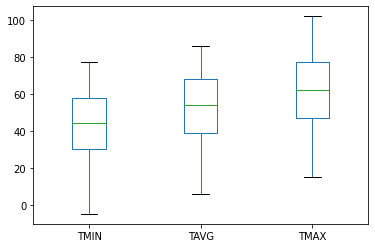

In [51]:
import matplotlib.pyplot as plt
print(weather[["TMIN", "TAVG", "TMAX"]].describe())
weather[["TMIN", "TAVG", "TMAX"]].plot(kind="box")
plt.show()

### Plotting the temperature difference


count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


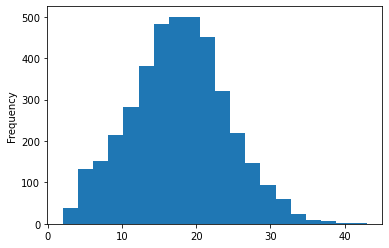

In [52]:
weather["TDIFF"] = weather["TMAX"] - weather["TMIN"]
print(weather.TDIFF.describe())
weather.TDIFF.plot(kind="hist", bins=20)
plt.show()

The TDIFF column has no negative values and its distribution is approximately normal, both of which are signs that the data is trustworthy.

## Categorizing the weather

### Counting bad weather conditions


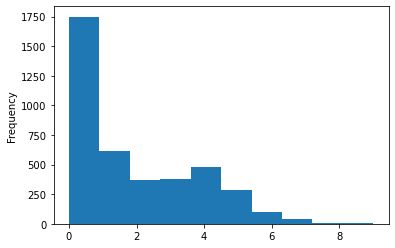

In [53]:
WT = weather.loc[:,"WT01":"WT22"]
weather["bad_conditions"] = WT.sum(axis = "columns")
weather["bad_conditions"] = weather.bad_conditions.fillna(0).astype("int")
weather.bad_conditions.plot(kind="hist")
plt.show()

### Rating the weather conditions

In [54]:
print(weather.bad_conditions.value_counts().sort_index())
mapping = {0:'good', 1:'bad', 2:'bad', 3:"bad", 4:"bad", 5:"worse",
6:"worse", 7:"worse", 8:"worse", 9:"worse"}
weather["rating"] = weather.bad_conditions.map(mapping)
print(weather["rating"].value_counts())

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
bad      1836
good     1749
worse     432
Name: rating, dtype: int64


### Changing the data type to category

The new way of creating ordered catergorical variables.

In [56]:
from pandas.api.types import CategoricalDtype
cats = ["good", "bad", "worse"]
weather['rating'] = weather.rating.astype(CategoricalDtype(categories=cats, ordered=True))
weather.rating.head()

0    bad
1    bad
2    bad
3    bad
4    bad
Name: rating, dtype: category
Categories (3, object): [good < bad < worse]

## Merging datasets

### Preparing the DataFrames

In [78]:
ri = pd.read_csv("police.csv")
ri["is_arrested"] = ri.is_arrested.astype("bool")
ri.dropna(subset=["driver_gender"], inplace=True)
ri.drop(["county_name", "state"], axis="columns", inplace=True)
combined = ri.stop_date.str.cat(ri.stop_time, sep=" ")
ri["stop_datetime"] = pd.to_datetime(combined)
mapping = {"0-15 Min":8, "16-30 Min":23, "30+ Min":45}
ri["stop_minutes"] = ri.stop_duration.map(mapping)
ri.reset_index(inplace=True)
print(ri.head())
weather_rating = weather[["DATE", "rating"]]
print(weather_rating.head())

   index   stop_date stop_time driver_gender driver_race  \
0      0  2005-01-04     12:55             M       White   
1      1  2005-01-23     23:15             M       White   
2      2  2005-02-17     04:15             M       White   
3      3  2005-02-20     17:15             M       White   
4      4  2005-02-24     01:20             F       White   

                    violation_raw  violation  search_conducted search_type  \
0  Equipment/Inspection Violation  Equipment             False         NaN   
1                        Speeding   Speeding             False         NaN   
2                        Speeding   Speeding             False         NaN   
3                Call for Service      Other             False         NaN   
4                        Speeding   Speeding             False         NaN   

    stop_outcome  is_arrested stop_duration  drugs_related_stop district  \
0       Citation        False      0-15 Min               False  Zone X4   
1       Citation  

### Merging the DataFrames

In [86]:
print(ri.shape)
ri_weather = pd.merge(left=ri, right=weather_rating, left_on="stop_date",
                    right_on="DATE", how="left")
print(ri_weather.shape)
ri_weather.set_index("stop_datetime", inplace=True)
ri_weather

(86536, 16)
(86536, 18)


,index,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,stop_minutes,DATE,rating
stop_datetime,,,,,,,,,,,,,,,,,
2005-01-04 12:55:00,0,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,8,2005-01-04,bad
2005-01-23 23:15:00,1,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,8,2005-01-23,worse
2005-02-17 04:15:00,2,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,8,2005-02-17,good
2005-02-20 17:15:00,3,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,23,2005-02-20,bad
2005-02-24 01:20:00,4,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,8,2005-02-24,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 21:21:00,91736,2015-12-31,21:21,F,Black,Other Traffic Violation,Moving violation,False,NaN,Citation,False,0-15 Min,False,Zone K2,8,2015-12-31,bad
2015-12-31 21:59:00,91737,2015-12-31,21:59,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,8,2015-12-31,bad
2015-12-31 22:04:00,91738,2015-12-31,22:04,M,White,Other Traffic Violation,Moving violation,False,NaN,Citation,False,0-15 Min,False,Zone X3,8,2015-12-31,bad


## Does weather affect the arrest rate?

Mean is the default aggregation function for a pivot table but another function can be chosen.

In [87]:
print(ri_weather.is_arrested.mean())
print(ri_weather.groupby("rating").is_arrested.mean())
print(ri_weather.groupby(["violation", "rating"]).is_arrested.mean())

0.0355690117407784
rating
good     0.033715
bad      0.036261
worse    0.041667
Name: is_arrested, dtype: float64
violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


The arrest rate increases as the weather gets worse, and that trend persists across many of the violation types.

### Selecting from a multi-indexed Series

The output of a single .groupby() operation on multiple columns is a Series with a MultiIndex. Working with this type of object is similar to working with a DataFrame.

In [90]:
arrest_rate = ri_weather.groupby(["violation", "rating"]).is_arrested.mean()
print(arrest_rate)
print("\n")
print(arrest_rate.loc["Moving violation", "bad"])
print(arrest_rate.loc["Speeding"])

violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


0.05804964058049641
rating
good     0.013405
bad      0.013314
worse    0.016886
Name: is_arrested, dtype: float64


### Reshaping the arrest rate data

In [93]:
print(arrest_rate.unstack())
print(ri_weather.pivot_table(index="violation", columns="rating", values="is_arrested"))

rating                   good       bad     worse
violation                                        
Equipment            0.059007  0.066311  0.097357
Moving violation     0.056227  0.058050  0.065860
Other                0.076966  0.087443  0.062893
Registration/plates  0.081574  0.098160  0.115625
Seat belt            0.028587  0.022493  0.000000
Speeding             0.013405  0.013314  0.016886
rating                   good       bad     worse
violation                                        
Equipment            0.059007  0.066311  0.097357
Moving violation     0.056227  0.058050  0.065860
Other                0.076966  0.087443  0.062893
Registration/plates  0.081574  0.098160  0.115625
Seat belt            0.028587  0.022493  0.000000
Speeding             0.013405  0.013314  0.016886
